In [1]:
import os
import re 
import pandas as pd
import numpy as np

from typing import List, Union, Tuple
from tqdm.auto import tqdm
tqdm.pandas()


In [19]:
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY=os.environ["OPENAI_API_KEY"]

In [3]:
from pgvector.sqlalchemy import Vector
from sentence_transformers import SentenceTransformer
from sqlalchemy import create_engine, insert, select, text, Integer, String, Text
from sqlalchemy.orm import declarative_base, mapped_column, Session


In [4]:
username = os.environ["USERNAME"]
password = os.environ["PASSWORD"]
hostname = os.environ["HOSTNAME"]
database = "embedding"
# database = os.environ["DATABASE"]
port = os.environ["PORT"]

db_credentials = f"postgresql://{username}:{password}@{hostname}:{port}/{database}"


In [5]:
engine = create_engine(db_credentials)
with engine.connect() as conn:
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    conn.commit()

Base = declarative_base()


In [6]:
df = pd.read_csv("ctgov_20230613_openai_embedding.csv", index_col="nct_id")
df


,brief_title,official_title,overall_status,baseline_measurements,brief_summaries,detailed_descriptions,criteria,gender,minimum_age,maximum_age,facilities,city,state,zip,country,recruitment_details,pre_assignment_details,study_type,embeddings
nct_id,,,,,,,,,,,,,,,,,,,
NCT00000143,Studies of Ocular Complications of AIDS (SOCA)...,Studies of Ocular Complications of AIDS (SOCA)...,Completed,NaN,"To compare the newest CMV retinitis drug, cido...",Cytomegalovirus (CMV) is among the most freque...,Inclusion criteria:\n\nAge 13 years or older\n...,All,13 Years,NaN,"University of South Florida, MDC Box 21",Tampa,Texas,94143,United States,June 1997,NaN,Interventional,"[-0.010117053490566939, 0.0014353180923144734,..."
NCT00000378,Antidepressant Treatment of Melancholia in Lat...,Antidepressant Treatment of Melancholia in Lat...,Completed,NaN,The purpose of this study is to compare the sa...,To compare the efficacy and safety of a select...,Inclusion Criteria:\n\n-\n\nPatients must have...,All,60 Years,95 Years,1051 Riverside Drive,New York,New York,10032,United States,NaN,NaN,Interventional,"[-0.013839153437317241, -0.003807755615505691,..."
NCT00000620,Action to Control Cardiovascular Risk in Diabe...,Action to Control Cardiovascular Risk in Diabe...,Completed,NaN,The purpose of this study is to prevent major ...,"BACKGROUND:\n\nCurrently, about 17 million Ame...",Inclusion Criteria:\n\nDiagnosed with type 2 d...,All,40 Years,79 Years,Wake Forest University,Winston-Salem,Washington,98195,United States,All participants had established type 2 diabet...,Eligible participants provided evidence of abi...,Interventional,"[-0.02645666465910675, -0.02204721930749222, 0..."
NCT00001213,Cysteamine Eye Drops to Treat Corneal Crystals...,Trial of Topical Cysteamine in the Treatment o...,Completed,Although 328 participants were initially enrol...,Cystinosis is an inherited disease that result...,"Protocol 86-EI-0062 began as a randomized, dou...",INCLUSION CRITERIA:\n\nPatients must have a do...,All,2 Years,NaN,"National Institutes of Health Clinical Center,...",Bethesda,Maryland,20892,United States,NaN,NaN,Interventional,"[0.0028949422587708743, -0.016361670996559528,..."
NCT00001259,A Treatment Study for Premenstrual Syndrome (PMS),The Treatment of Menstrually-Related Mood Diso...,Completed,NaN,This study examines the effects of estrogen an...,This protocol is designed to accompany Clinica...,INCLUSION CRITERIA:\n\nThe subjects of this st...,Female,18 Years,45 Years,"National Institutes of Health Clinical Center,...",Bethesda,Maryland,20892,United States,One participant signed consent but withdrew pr...,"8 of 46 participants who completed Study 2, Ph...",Interventional,"[-0.040142119659849006, 0.001966558432531476, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCT05451225,Survey of Correction Officers Before and After...,Reducing Duration of Untreated Psychosis Throu...,Completed,NaN,The investigators will implement a multifacete...,Because Correction Officers in the three jails...,Inclusion Criteria:\n\nCorrection Officers;\no...,All,21 Years,NaN,Columbia University,New York,New York,10027,United States,Recruitment of the study sample took place in ...,Correction officers (COs) were recruited at ea...,Interventional,"[-0.02336861067497135, -0.01617507119686338, 0..."
NCT05489146,t-RNS After Hand Recovery in Chronic Stroke,Combining Transcranial Random Noise Stimulatio...,Completed,Fugl Meyer Upper Extremity Assessment (FMUE) m...,Upper extremity (UE) paresis or weakness is on...,The primary purpose of this study was to inves...,Inclusion Criteria:\n\nAge 18 or older\nEpisod...,All,18 Years,80 Years,Neuromotor Recovery and Rehabilitation Lab,Pittsburgh,Pennsylvania,15260,United States,NaN,NaN,Interventional,"[-0.04131284136615776, 0.0042052526653315984, ..."
NCT05502081,Clinical Study to Compare Efficacy and Safety ...,Clinical Study to Evaluate the Possible Effica...,Completed,0. Uninfected\n\nAmbulatory mi

In [7]:
embeddings = df["embeddings"].copy()
embeddings = embeddings.progress_apply(lambda x: np.fromstring(
    re.sub(r'[\n\[\]]', '', x), sep=',').astype(np.float32)
)
embeddings[0]


  0%|          | 0/28623 [00:00<?, ?it/s]

array([-0.01011705,  0.00143532,  0.01915826, ..., -0.0248823 ,
       -0.01993066, -0.02074444], dtype=float32)

### Write to database

In [8]:
documents = df.to_dict(orient="records")


In [9]:
class Document(Base):
    __tablename__ = 'openai'
    
    nct_id = mapped_column(String, primary_key=True)
    brief_title = mapped_column(Text)
    official_title = mapped_column(Text)
    baseline_measurements = mapped_column(Text)
    brief_summaries = mapped_column(Text)
    detailed_descriptions = mapped_column(Text)
    criteria = mapped_column(Text)
    gender = mapped_column(Text)
    minimum_age = mapped_column(Text)
    maximum_age = mapped_column(Text)
    facilities = mapped_column(Text)
    city = mapped_column(Text)
    state = mapped_column(Text)
    zip = mapped_column(Text)
    country = mapped_column(Text)
    recruitment_details = mapped_column(Text)
    pre_assignment_details = mapped_column(Text)
    study_type = mapped_column(Text)
    embedding = mapped_column(Vector(embeddings[0].shape[0]))


Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)


In [10]:
documents = [
    dict(
        nct_id=df.index[i],
        brief_title=df["brief_title"].iloc[i],
        official_title=df["official_title"].iloc[i],
        baseline_measurements=df["baseline_measurements"].iloc[i],
        brief_summaries=df["brief_summaries"].iloc[i],
        detailed_descriptions=df["detailed_descriptions"].iloc[i],
        criteria=df["criteria"].iloc[i],
        gender=df["gender"].iloc[i],
        minimum_age=df["minimum_age"].iloc[i],
        maximum_age=df["maximum_age"].iloc[i],
        facilities=df["facilities"].iloc[i],
        city=df["city"].iloc[i],
        state=df["state"].iloc[i],
        zip=df["zip"].iloc[i],
        country=df["country"].iloc[i],
        recruitment_details=df["recruitment_details"].iloc[i],
        pre_assignment_details=df["pre_assignment_details"].iloc[i],
        study_type=df["study_type"].iloc[i],
        embedding=embedding
    ) for i, embedding in enumerate(embeddings)
]


In [11]:
session = Session(engine)


In [12]:
session.execute(insert(Document), documents)
session.commit()


### Clustering the trials

In [13]:
import umap
import umap.plot


2023-06-19 11:10:27.860082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 11:10:27.960124: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-19 11:10:28.357297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-19 11:10:28.357340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [14]:
array = np.stack(embeddings)
array.shape


(28623, 1536)

In [15]:
reduced_embeddings = umap.UMAP().fit(array)


<Axes: >

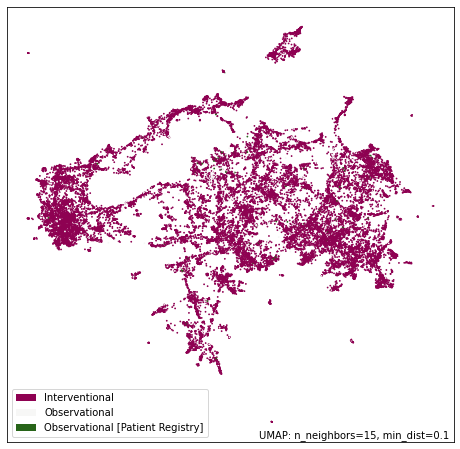

In [16]:

umap.plot.points(
    reduced_embeddings,
    labels=df["study_type"], 
    color_key_cmap='PiYG',
    )


### Search by trials

In [17]:
doc = session.get(Document, "NCT00000143")
neighbors = session.scalars(
    select(Document)
    .filter(Document.nct_id != doc.nct_id)
    .order_by(Document.embedding.cosine_distance(doc.embedding))
    .limit(5))
for neighbor in neighbors:
    print("="*80)
    print(neighbor.nct_id)
    print(neighbor.official_title)
    print(neighbor.detailed_descriptions)
    # print(neighbor.criteria)


NCT01335932
A Randomized Double-Blind Placebo-Controlled Trial of Ganciclovir/Valganciclovir for Prevention of Cytomegalovirus Reactivation in Acute Injury of the Lung and Respiratory Failure (The GRAIL Study)
Critical illness due to severe sepsis and trauma are major causes of morbidity and mortality, and a substantial economic burden in the United States and worldwide. Despite advances in clinical care, patients with sepsis and trauma-associated respiratory failure represent specific populations with high rates of adverse outcomes. The etiology of respiratory failure in patients with severe sepsis and trauma is multifactorial, but acute lung injury (ALI) is one of the leading causes, and is associated with prolonged ICU and hospital stays, mortality, and long-term sequelae. Other than general supportive care, few specific interventions other than lung protective ventilation have been shown to improve outcomes in such patients. New approaches for understanding the pathogenesis and dev

### Search by query

In [23]:
from scipy import spatial
import time
from langchain.embeddings import OpenAIEmbeddings


model = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

def cosine_similarity(a, b):
    return 1 - spatial.distance.cosine(a, b)


def _generate_embedding(
    text=None,
    model=None,
    amount=0,
):
    assert model is not None
    embedding = model.embed_documents([text])
    time.sleep(amount)
    embedding = np.array(embedding).squeeze()
    return embedding

In [24]:
query = "HyperTension with Breast Cancer"

qry_embeddding = _generate_embedding(query, model=model)

print(len(qry_embeddding))
neighbors = session.scalars(
    select(Document)
    # l2 distance
    .order_by(Document.embedding.cosine_distance(qry_embeddding.tolist()))
    .limit(5))
for neighbor in neighbors:
    print("="*80)
    print(neighbor.nct_id)
    print(neighbor.official_title)
    print(neighbor.detailed_descriptions)
    # print(neighbor.criteria)


1536
NCT01733628
Evaluation Study of Hypertension as a Predictor of Efficacy Bevacizumab (BV) in Combination With Chemotherapy (CT) in Metastatic Colorectal Cancer (MCC) and Metastatic Breast Cancer (MBC).
Hypertension (HT) is the most common side effect seen in trials of bevacizumab in combination with chemotherapy. Based on the hypothesis that the development of hypertension during treatment would be an indicative of the successful blockade of the Vascular Endothelial Growth Factor (VEGF) pathway, different studies have explored retrospectively the relationship between hypertension and the results of treatment with bevacizumab.

This study aims to demonstrate the association between hypertension (diagnosed optimally) with efficacy to treatment with bevacizumab prospectively and secondly verify if blood pressure measures taken at home are a reflection of a diagnosis of hypertension.

Also have been explored different molecular markers involved in the pathway of VEGF which might be use

In [25]:
query = "Diabetes for men"

qry_embeddding = _generate_embedding(query, model=model)

print(len(qry_embeddding))
neighbors = session.scalars(
    select(Document)
    # l2 distance
    .order_by(Document.embedding.cosine_distance(qry_embeddding.tolist()))
    .limit(5))
for neighbor in neighbors:
    print("="*80)
    print(neighbor.nct_id)
    print(neighbor.official_title)
    print(neighbor.detailed_descriptions)
    # print(neighbor.criteria)


1536
NCT01127659
Effect of Hypogonadotrophic Hypogonadism and Treatment With Testosterone on Insulin Sensitivity, Inflammation, Body Composition and Sexual Function in Obese and Type 2 Diabetic Men
Hypogonadotropic hypogonadism (HH) occurs in approximately one-third of obese and type 2 diabetic men. Considering that there are 24 million diabetic and 100 million obese people, of which half are males, obesity and type 2 diabetes potentially constitute the major cause of hypogonadism in the population. We hypothesize that 1) HH in obese and type 2 diabetic men is associated with decreased insulin sensitivity, increased fat tissue mass, decreased lean body mass, increased inflammatory and oxidative stress, impaired sexual function and depressed mood as compared to diabetic and obese men with normal testosterone concentrations; and that 2) testosterone replacement for 24 weeks in men with HH leads to an improvement in these parameters. Our proposed study would be the first prospective, rand